# 179개의 데이터로 Transfer_Learning 하기

- 논문의 모델에 179개의 데이터를 넣고 학습을 시켜보자

## Step 1. 실험환경 set-up

#### 라이브러리 실행

In [1]:
from tensorflow.keras             import utils, regularizers
from tensorflow.keras.models      import Sequential, load_model
from tensorflow.keras.layers      import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers  import Adam
from tensorflow.keras.constraints import MaxNorm
from sklearn.model_selection      import train_test_split  # 데이터 전처리에 필요한 패키지

import os                       # I/O 관련된 작업에 필요한 패키지 
import numpy             as np  # 데이터 array 작업에 필요한 패키지
import tensorflow        as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt # 데이터 시각화에 관련된 작업에 필요한 패키지

import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지
from PIL import Image

#### 필요한 변수들 생성

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# BATCH_SIZE 변수
BATCH_SIZE = 32

# 이미지 사이즈 변수
IMAGE_SIZE = [1024, 1360]

# EPOCH 크기 변수
EPOCHS = 150

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Step 2. 데이터 준비하기

먼저 아래의 링크에서 데이터를 다운 받을 것

https://drive.google.com/drive/folders/1Pi5qyX080zY2IdGT1TvvLraBO9DHBxJl?usp=sharing

받은 후 터미널 창에 아래의 명령어들을 차례로 입력

```
$ cd ~/Downloads && cp CellPin ~/aiffel
```

#### 데이터의 개수 확인

In [4]:
# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), '/workspace/storage')
print(ROOT_PATH)

train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/CellPin/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/CellPin/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/CellPin/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

/workspace/storage
782
104
126


#### train과 validation을 80:20으로 분할

In [5]:
# filenames = tf.io.gfile.glob(str(ROOT_PATH + '/train/*/*'))
# filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/val/*/*')))

# train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

# print(len(train_filenames))
# print(len(val_filenames))

#### train 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "normal" in filename])
print("NORMAL images count in training set: " + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in train_filenames if "cpe" in filename])
print("CPE images count in training set: " + str(COUNT_CPE))

NORMAL images count in training set: 355
CPE images count in training set: 427


#### val 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [7]:
COUNT_NORMAL = len([filename for filename in val_filenames if "normal" in filename])
print("NORMAL images count in training set: " + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in val_filenames if "cpe" in filename])
print("CPE images count in training set: " + str(COUNT_CPE))

NORMAL images count in training set: 50
CPE images count in training set: 76


#### test 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [8]:
COUNT_NORMAL = len([filename for filename in test_filenames if "normal" in filename])
print("NORMAL images count in training set: " + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in test_filenames if "cpe" in filename])
print("CPE images count in training set: " + str(COUNT_CPE))

NORMAL images count in training set: 40
CPE images count in training set: 64


#### tf.data 인스턴스를 만들기

In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

#### train data와 val data의 개수 확인

In [10]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 782
Validating images count: 126


#### 라벨 이름들 확인

In [11]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/CellPin/train/*"))])
print(CLASS_NAMES)

['normal' 'cpe']


#### 라벨링 함수를 만들어 보기

In [12]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "cpe"

#### decode_img 함수와 process_path 함수를 만들기

In [13]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=1)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    if label == True:
        label = ([0, 1])    # cpe
    else:
        label = ([1, 0])    # normal
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

#### train과 val에 함수들 적용해주기

In [14]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

#### 전처리 함수 만들기 및 적용

In [15]:
def augment(image,label):
    image = tf.image.flip_left_right(image)  # 좌우 반전
    image = tf.image.flip_up_down(image)  # 상하 반전
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000, with_aug=False):
    
    if  with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
            )    

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [16]:
train_ds_no_aug = prepare_for_training(train_ds, with_aug=False)
val_ds_no_aug = prepare_for_training(val_ds, with_aug=False)


train_ds_aug = prepare_for_training(train_ds, with_aug=True)
val_ds_aug = prepare_for_training(val_ds, with_aug=True)

#### Image shape를 변경 체크하기

In [17]:
for image, label in train_ds_no_aug.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy().shape)

Image shape:  (32, 1024, 1360, 1)
Label:  (32, 2)


In [18]:
for image, label in train_ds_aug.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy().shape)

Image shape:  (32, 1024, 1360, 1)
Label:  (32, 2)


#### test 데이터 셋도 만들어 보기 & 데이터의 갯수 확인

In [19]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/CellPin/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

104


## Step 3. 데이터 시각화

#### 16개의 샘플 꺼내서 확인

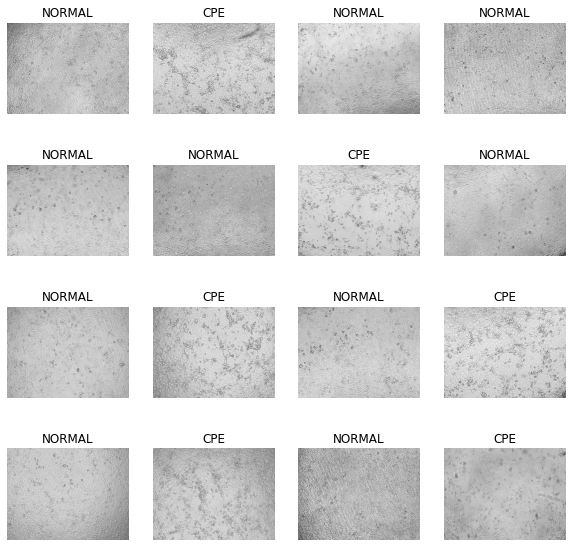

In [20]:
image_batch, label_batch = next(iter(train_ds_no_aug))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n], cmap='gray')
        if list(label_batch[n])[0].numpy() == 0:
            plt.title("CPE")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch)

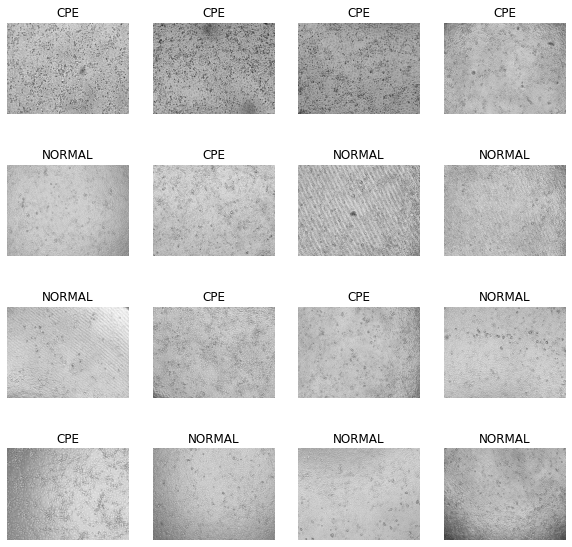

In [21]:
image_batch, label_batch = next(iter(train_ds_aug))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n], cmap='gray')
        if list(label_batch[n])[0].numpy() == 0:
            plt.title("CPE")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch)

#### model building

In [22]:
no_aug_model = load_model(ROOT_PATH + "/rkp/Model-Architecture-main/0816_influ_filter_model_1")
with_aug_model = load_model(ROOT_PATH + "/rkp/Model-Architecture-main/0816_influ_filter_model_1")

In [23]:
no_aug_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_conv_layer (Conv2D)    (None, 1018, 1354, 20)    1000      
_________________________________________________________________
activation_1 (Activation)    (None, 1018, 1354, 20)    0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 101, 135, 20)      0         
_________________________________________________________________
second_conv_layer (Conv2D)   (None, 97, 131, 25)       12525     
_________________________________________________________________
activation_2 (Activation)    (None, 97, 131, 25)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 21, 25)        0         
_________________________________________________________________
third_conv_layer (Conv2D)    (None, 14, 19, 30)        6

In [24]:
with_aug_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_conv_layer (Conv2D)    (None, 1018, 1354, 20)    1000      
_________________________________________________________________
activation_1 (Activation)    (None, 1018, 1354, 20)    0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 101, 135, 20)      0         
_________________________________________________________________
second_conv_layer (Conv2D)   (None, 97, 131, 25)       12525     
_________________________________________________________________
activation_2 (Activation)    (None, 97, 131, 25)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 21, 25)        0         
_________________________________________________________________
third_conv_layer (Conv2D)    (None, 14, 19, 30)       

## Step 5. 데이터 imbalance 처리

#### 이 weight들은 'Normal'과 'Cpe' 전체 데이터 건수에 반비례하도록 설정

In [25]:
# weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
# weight_for_1 = (1 / COUNT_CPE)*(TRAIN_IMG_COUNT)/2.0

# class_weight = {0: weight_for_0, 1: weight_for_1}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))

## Step 6. 모델 훈련

#### GPU사용하여 model complie

In [26]:
with tf.device('/GPU:0'):
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    no_aug_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2, restore_best_weights = True)
    no_aug_check_point = tf.keras.callbacks.ModelCheckpoint('best_model_pretrain_no_aug.h5')

In [27]:
with tf.device('/GPU:0'):

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    no_aug_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2, restore_best_weights = True)
    with_aug_check_point = tf.keras.callbacks.ModelCheckpoint('best_model_pretrain_with_aug.h5')

#### 모델 fitting

In [28]:
with tf.device('/GPU:0'):
    history_no_aug_model = no_aug_model.fit(
        train_ds_no_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_no_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
#         class_weight=class_weight,
        callbacks=[no_aug_check_point]
    )

Epoch 1/150
24/24 [==============================] - 112s 2s/step - loss: 0.7051 - accuracy: 0.6051 - precision: 0.6051 - recall: 0.6051 - val_loss: 0.7138 - val_accuracy: 0.4792 - val_precision: 0.4792 - val_recall: 0.4792
Epoch 2/150
24/24 [==============================] - 56s 2s/step - loss: 0.6561 - accuracy: 0.6220 - precision: 0.6220 - recall: 0.6220 - val_loss: 0.6332 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 0.6250
Epoch 3/150
24/24 [==============================] - 59s 3s/step - loss: 0.5973 - accuracy: 0.7057 - precision: 0.7057 - recall: 0.7057 - val_loss: 0.6514 - val_accuracy: 0.6146 - val_precision: 0.6146 - val_recall: 0.6146
Epoch 4/150
24/24 [==============================] - 64s 3s/step - loss: 0.6221 - accuracy: 0.6614 - precision: 0.6614 - recall: 0.6614 - val_loss: 0.6112 - val_accuracy: 0.6979 - val_precision: 0.6979 - val_recall: 0.6979
Epoch 5/150
24/24 [==============================] - 54s 2s/step - loss: 0.5931 - accuracy: 0.6662 - precis

Epoch 38/150
24/24 [==============================] - 53s 2s/step - loss: 0.1213 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - val_loss: 0.4614 - val_accuracy: 0.8125 - val_precision: 0.8125 - val_recall: 0.8125
Epoch 39/150
24/24 [==============================] - 53s 2s/step - loss: 0.2053 - accuracy: 0.9156 - precision: 0.9156 - recall: 0.9156 - val_loss: 0.3303 - val_accuracy: 0.8646 - val_precision: 0.8646 - val_recall: 0.8646
Epoch 40/150
24/24 [==============================] - 54s 2s/step - loss: 0.2029 - accuracy: 0.9144 - precision: 0.9144 - recall: 0.9144 - val_loss: 0.1801 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375
Epoch 41/150
24/24 [==============================] - 53s 2s/step - loss: 0.1649 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - val_loss: 0.1876 - val_accuracy: 0.9167 - val_precision: 0.9167 - val_recall: 0.9167
Epoch 42/150
24/24 [==============================] - 54s 2s/step - loss: 0.1421 - accuracy: 0.9519 - pr

24/24 [==============================] - 53s 2s/step - loss: 0.0360 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2283 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375
Epoch 75/150
24/24 [==============================] - 53s 2s/step - loss: 0.0293 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1668 - val_accuracy: 0.9271 - val_precision: 0.9271 - val_recall: 0.9271
Epoch 76/150
24/24 [==============================] - 53s 2s/step - loss: 0.0261 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1758 - val_accuracy: 0.9271 - val_precision: 0.9271 - val_recall: 0.9271
Epoch 77/150
24/24 [==============================] - 54s 2s/step - loss: 0.0258 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1083 - val_accuracy: 0.9479 - val_precision: 0.9479 - val_recall: 0.9479
Epoch 78/150
24/24 [==============================] - 53s 2s/step - loss: 0.0265 - accuracy: 0.9997 - precision: 0.99

24/24 [==============================] - 53s 2s/step - loss: 0.0149 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1296 - val_accuracy: 0.9479 - val_precision: 0.9479 - val_recall: 0.9479
Epoch 111/150
24/24 [==============================] - 53s 2s/step - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1561 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375
Epoch 112/150
24/24 [==============================] - 54s 2s/step - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1354 - val_accuracy: 0.9479 - val_precision: 0.9479 - val_recall: 0.9479
Epoch 113/150
24/24 [==============================] - 53s 2s/step - loss: 0.0140 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1148 - val_accuracy: 0.9688 - val_precision: 0.9688 - val_recall: 0.9688
Epoch 114/150
24/24 [==============================] - 53s 2s/step - loss: 0.0136 - accuracy: 1.0000 - precision: 

24/24 [==============================] - 53s 2s/step - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1722 - val_accuracy: 0.9479 - val_precision: 0.9479 - val_recall: 0.9479
Epoch 147/150
24/24 [==============================] - 53s 2s/step - loss: 0.0125 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1325 - val_accuracy: 0.9583 - val_precision: 0.9583 - val_recall: 0.9583
Epoch 148/150
24/24 [==============================] - 53s 2s/step - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1752 - val_accuracy: 0.9479 - val_precision: 0.9479 - val_recall: 0.9479
Epoch 149/150
24/24 [==============================] - 53s 2s/step - loss: 0.0123 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1459 - val_accuracy: 0.9583 - val_precision: 0.9583 - val_recall: 0.9583
Epoch 150/150
24/24 [==============================] - 53s 2s/step - loss: 0.0125 - accuracy: 1.0000 - precision: 

In [29]:
with tf.device('/GPU:0'):
    history_with_aug_model = with_aug_model.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
#         class_weight=class_weight,
        callbacks=[with_aug_check_point]
    )

Epoch 1/150
24/24 [==============================] - 102s 2s/step - loss: 0.7166 - accuracy: 0.5573 - val_loss: 0.7755 - val_accuracy: 0.3750
Epoch 2/150
24/24 [==============================] - 58s 3s/step - loss: 0.6508 - accuracy: 0.5833 - val_loss: 0.6080 - val_accuracy: 0.6875
Epoch 3/150
24/24 [==============================] - 61s 3s/step - loss: 0.5835 - accuracy: 0.7096 - val_loss: 0.6007 - val_accuracy: 0.7083
Epoch 4/150
24/24 [==============================] - 66s 3s/step - loss: 0.5384 - accuracy: 0.7188 - val_loss: 0.6921 - val_accuracy: 0.5521
Epoch 5/150
24/24 [==============================] - 56s 2s/step - loss: 0.4961 - accuracy: 0.7591 - val_loss: 0.4607 - val_accuracy: 0.7812
Epoch 6/150
24/24 [==============================] - 54s 2s/step - loss: 0.4513 - accuracy: 0.8073 - val_loss: 0.6434 - val_accuracy: 0.6146
Epoch 7/150
24/24 [==============================] - 56s 2s/step - loss: 0.4200 - accuracy: 0.8281 - val_loss: 0.5671 - val_accuracy: 0.6979
Epoch 8/150


KeyboardInterrupt: 

## Step 7. 결과 확인 및 시각화

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_no_aug_model.history[met])
    ax[i].plot(history_no_aug_model.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_with_aug_model.history[met])
    ax[i].plot(history_with_aug_model.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## Step 8. 최종 Test dataset 검정하기

In [ ]:
no_aug_model = tf.keras.models.load_model("best_model_pretrain_no_aug.h5")
loss, acc, prec, rec = no_aug_model.evaluate(test_ds)

In [ ]:
with_aug_model = tf.keras.models.load_model("best_model_pretrain_with_aug.h5")
loss, acc, prec, rec = with_aug_model.evaluate(test_ds)

## Discussion